In [1]:
import metapy

In [2]:
metapy.__version__

'0.2.10'

In [3]:
metapy.log_to_stderr()

In [4]:
import urllib.request
import os
import tarfile

if not os.path.isdir('data'):
    os.mkdir('data')

if not os.path.exists('data/lemur-stopwords.txt'):
    urllib.request.urlretrieve('https://raw.githubusercontent.com/meta-toolkit/meta/master/data/lemur-stopwords.txt',
                               'data/lemur-stopwords.txt')
    
if not os.path.exists('data/nips.tar.gz'):
    urllib.request.urlretrieve('https://meta-toolkit.org/data/2018-06-20/nips.tar.gz',
                               'data/nips.tar.gz')
    
if not os.path.isdir('data/nips'):
    with tarfile.open('data/nips.tar.gz', 'r:gz') as nipsgz:
        nipsgz.extractall('data/nips')

In [5]:
fidx = metapy.index.make_forward_index('nips.toml')

1529531274: [info]     Creating forward index: nips-idx/fwd (/tmp/pip-req-build-m473bt6z/deps/meta/src/index/forward_index.cpp:239)
 > Tokenizing Docs: [===================================>    ]  88% ETA 00:00:00   
1529531276: [warning]  Empty document (id = 1435) generated! (/tmp/pip-req-build-m473bt6z/deps/meta/src/index/forward_index.cpp:335)
 > Tokenizing Docs: [========================================] 100% ETA 00:00:00 
 > Merging: [================================================] 100% ETA 00:00:00 
1529531276: [info]     Done creating index: nips-idx/fwd (/tmp/pip-req-build-m473bt6z/deps/meta/src/index/forward_index.cpp:278)


In [6]:
dset = metapy.classify.MulticlassDataset(fidx)

 > Loading instances into memory: [==========================] 100% ETA 00:00:00 


In [6]:
model = metapy.topics.LDAParallelGibbs(docs=dset, num_topics=10, alpha=0.1, beta=0.1)
model.run(num_iters=1000)
model.save('lda-pgibbs-nips')

Initialization log likelihood (log P(W|Z)): -3.05368e+07                          
Iteration 1 log likelihood (log P(W|Z)): -3.05047e+07                              
Iteration 2 log likelihood (log P(W|Z)): -3.04192e+07                              
Iteration 3 log likelihood (log P(W|Z)): -3.034e+07                                
Iteration 4 log likelihood (log P(W|Z)): -3.0266e+07                               
Iteration 5 log likelihood (log P(W|Z)): -3.01972e+07                              
Iteration 6 log likelihood (log P(W|Z)): -3.0136e+07                               
Iteration 7 log likelihood (log P(W|Z)): -3.0078e+07                               
Iteration 8 log likelihood (log P(W|Z)): -3.00232e+07                             
Iteration 9 log likelihood (log P(W|Z)): -2.99751e+07                             
Iteration 10 log likelihood (log P(W|Z)): -2.99292e+07                            
Iteration 11 log likelihood (log P(W|Z)): -2.98865e+07                          

In [7]:
model = metapy.topics.TopicModel('lda-pgibbs-nips')

 > Loading topic term probabilities: [=======================] 100% ETA 00:00:00 
 > Loading document topic probabilities: [===================] 100% ETA 00:00:00 


In [8]:
for topic in range(0, model.num_topics()):
    print("Topic {}:".format(topic + 1))
    for tid, val in model.top_k(topic, 10, metapy.topics.BLTermScorer(model)):
        print("{}: {}".format(fidx.term_text(tid), val))
    print("======\n")

Topic 1:
classifi: 0.030811178675959616
loss: 0.029994852557605475
bound: 0.029220520851604634
risk: 0.024621732701050992
theorem: 0.024539586062751622
kernel: 0.024356018356251632
label: 0.019930365388734116
xi: 0.017945407989225975
distribut: 0.015971975930189067
classif: 0.013140751106377444

Topic 2:
convex: 0.06472844201840627
gradient: 0.04122571196329661
algorithm: 0.03717930246510566
converg: 0.03388880656376636
xt: 0.027600539166103367
optim: 0.02503304478120115
iter: 0.023658506484983466
theorem: 0.02026764696541772
xk: 0.019995793112998927
descent: 0.019342152910693723

Topic 3:
neuron: 0.10425089469826113
spike: 0.08485063584526907
stimulus: 0.032065005177503283
cell: 0.02868554705307691
respons: 0.026819331623486823
signal: 0.021569761210171914
brain: 0.02012264070858083
synapt: 0.01709928587160956
stimuli: 0.017098122424535678
tempor: 0.01681376123882035

Topic 4:
matrix: 0.05745899186941871
kernel: 0.04215310382940012
rank: 0.027937892536651823
estim: 0.02057059327240127

In [9]:
import pandas as pd

data = []
for doc in dset:
    proportions = model.topic_distribution(doc.id)
    data.append([dset.label(doc)] + [proportions.probability(i) for i in range(0, model.num_topics())])
df = pd.DataFrame(data, columns=['label'] + ["Topic {}".format(i + 1) for i in range(0, model.num_topics())])

Topic 1


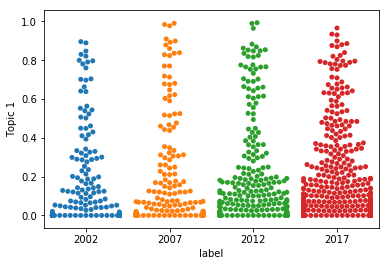

Topic 2


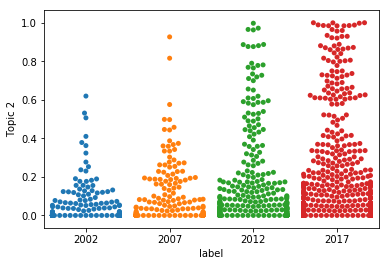

Topic 3


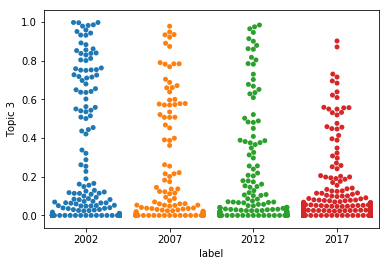

Topic 4


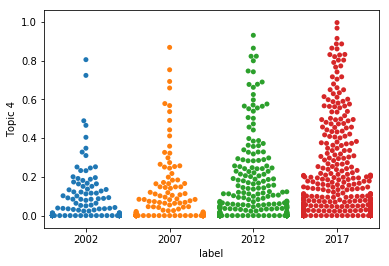

Topic 5


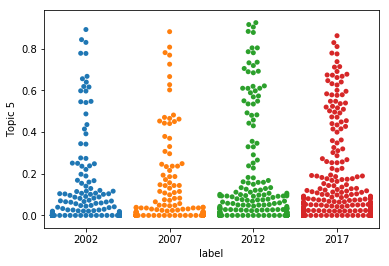

Topic 6


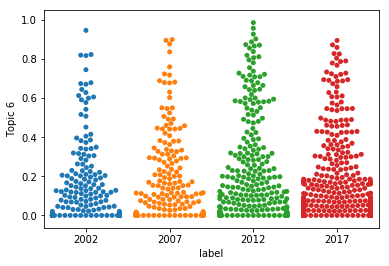

Topic 7


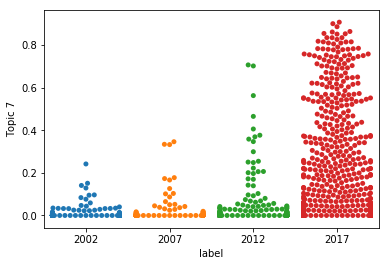

Topic 8


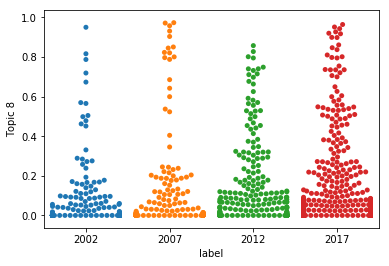

Topic 9


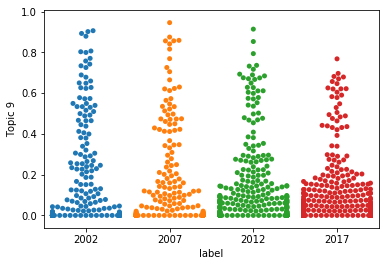

Topic 10


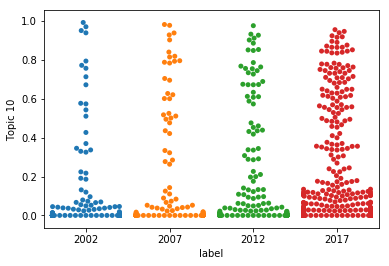

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(0, model.num_topics()):
    print("Topic {}".format(i + 1))
    sns.swarmplot(data=df, x='label', y="Topic {}".format(i + 1))
    plt.show()

In [11]:
shuffled_view = metapy.classify.MulticlassDatasetView(dset)
shuffled_view.shuffle()

words_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    dset.total_features(),
    lambda doc: metapy.learn.FeatureVector(doc.weights),
    lambda doc: dset.label(doc)
)

topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view if dset.label(doc) == "2002" or dset.label(doc) == "2017"],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

In [12]:
words_train = words_dset[0:int(len(words_dset)/2)]
words_test = words_dset[int(len(words_dset)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [13]:
def make_linear_svm(training):
    return metapy.classify.OneVsAll(training, metapy.classify.SGD, loss_id='hinge')

words_sgd = make_linear_svm(words_train)
topics_sgd = make_linear_svm(topics_train)

print("Words:")
mtrx = words_sgd.test(words_test)
print(mtrx)
mtrx.print_stats()

print("======")
print("Topics:")
mtrx = topics_sgd.test(topics_test)
print(mtrx)
mtrx.print_stats()

Words:

           2002     2017     
         ------------------
    2002 | 0.908    0.0917   
    2017 | 0.018    0.982    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.925       0.943       0.908       0.246       
2017        0.976       0.97        0.982       0.754       
------------------------------------------------------------
Total       0.964       0.964       0.964       
------------------------------------------------------------
443 predictions attempted, overall accuracy: 0.964

Topics:

           2002     2017     
         ------------------
    2002 | 0.532    0.468    
    2017 | 0.0419   0.958    


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.641       0.806   

In [14]:
topic_dset = metapy.classify.MulticlassDataset(
    [doc for doc in shuffled_view],
    model.num_topics(),
    lambda doc: metapy.learn.FeatureVector((i, model.topic_probability(doc.id, i)) for i in range(0, model.num_topics())),
    lambda doc: dset.label(doc)
)

words_train = shuffled_view[0:int(len(shuffled_view)/2)]
words_test = shuffled_view[int(len(shuffled_view)/2):]

topics_train = topic_dset[0:int(len(topic_dset)/2)]
topics_test = topic_dset[int(len(topic_dset)/2):]

In [15]:
words_svm = make_linear_svm(words_train)
topics_svm = make_linear_svm(topics_train)

words_mtrx = words_svm.test(words_test)
topics_mtrx = topics_svm.test(topics_test)

print("Words:")
print(words_mtrx)
words_mtrx.print_stats()

print("========")
print("Topics:")
print(topics_mtrx)
topics_mtrx.print_stats()

Words:

           2002     2007     2012     2017     
         ------------------------------------
    2002 | 0.734    0.128    0.101    0.0367   
    2007 | 0.267    0.257    0.39     0.0857   
    2012 | 0.0691   0.207    0.452    0.271    
    2017 | 0.00898  0.021    0.0599   0.91     


------------------------------------------------------------
Class       F1 Score    Precision   Recall      Class Dist  
------------------------------------------------------------
2002        0.687       0.645       0.734       0.148       
2007        0.281       0.31        0.257       0.143       
2012        0.493       0.541       0.452       0.255       
2017        0.866       0.826       0.91        0.454       
------------------------------------------------------------
Total       0.663       0.653       0.674       
------------------------------------------------------------
736 predictions attempted, overall accuracy: 0.674

Topics:

           2002     2007     2012     2017   